In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras import layers, models
import time
no = "2"
# example_filename = os.path.join(data_path, 'example4d.nii.gz')
img1 = nib.load('D:/projects/finalProject/nifti/{}/image.nii.gz'.format(no))
img2 = nib.load('D:/projects/finalProject/nifti/{}/mask.nii.gz'.format(no))
xn = img1.shape[0]
yn = img1.shape[1]
zn = img1.shape[2]
d1 = img1.get_data()
d2 = img2.get_data()
w0 = 2
w1 = 50
imgs = { }
def readFile(no):
    global imgs
    # example_filename = os.path.join(data_path, 'example4d.nii.gz')
    img1 = nib.load('D:/projects/finalProject/nifti/{}/image.nii.gz'.format(no))
    img2 = nib.load('D:/projects/finalProject/nifti/{}/mask.nii.gz'.format(no))
    xn = img1.shape[0]
    yn = img1.shape[1]
    zn = img1.shape[2]
    dImg = img1.get_data()
    dMask = img2.get_data()
    
    f = open('D:/projects/finalProject/nifti/{}/ranges.txt'.format(no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'xn': xn, 'yn': yn, 'zn': zn, 'dImg': dImg, 'dMask': dMask, 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }

In [ ]:
def readImgBound(no):
    f = open('D:/projects/finalProject/nifti/{}/ranges.txt'.format(no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }

In [ ]:
allBounds = { }
def readBoundAndShow():
    global allBounds
    print("w, h, d")
    w = 0
    h = 0
    d = 0
    for i in range(1, 101):
        bound = readImgBound(i)
        print("{}, {}, {}".format(bound["width"], bound["height"], bound["depth"]))
        if w < bound["width"]:
            w = bound["width"]
        if h < bound["height"]:
            h = bound["height"]
        if d < bound["depth"]:
            d = bound["depth"]
    print("max: {}, {}, {}".format(w, h, d))
    allBounds["w"] = w
    allBounds["h"] = h
    allBounds["d"] = d
readBoundAndShow()

In [ ]:
allBounds

{'w': 150, 'h': 169, 'd': 195}

In [ ]:
def getImg(z, y0 = 0, y1 = yn, x0 = 0, x1 = xn, dataConstant = True, vLow = 120, vHigh = 2000, ds = [ ], minValue = -2000, maxValue = 0):
    data = [ ]
    for y in range(y0, y1):
        dy = [ ]
        for x in range(x0, x1):
            if ds[x][y][z] > vLow and ds[x][y][z] < vHigh:
                if dataConstant:
                    dy.append(maxValue)
                else:
                    dy.append(ds[x][y][z])
            else:
                dy.append(minValue)
        data.append(dy)
    return data
def getImgBound(imgNo = 2, z = 0, dataConstant = True, vLow = 120, vHigh = 2000, ds = 'dImg', minValue = -2000, maxValue = 0):
    global imgs, allBounds
    if str(imgNo) not in imgs:
        imgs = { }
        imgs[str(imgNo)] = readFile(imgNo)
    imgBound = imgs[str(imgNo)]
    x0 = imgBound["x0"]
    x1 = imgBound["x1"]
    y0 = imgBound["y0"]
    y1 = imgBound["y1"]
    if imgBound["width"] < allBounds["w"]:
        x0 = x0 - int((allBounds["w"] - imgBound["width"]) / 2)
        x1 = x0 + allBounds["w"]
    if imgBound["height"] < allBounds["h"]:
        y0 = y0 - int((allBounds["h"] - imgBound["height"]) / 2)
        y1 = y0 + allBounds["h"]
    # print("x0: {}, x1: {}, y0: {}, y1: {}".format(x0, x1, y0, y1))
    return getImg(imgBound["b"] + z, y0, y1, x0, x1, dataConstant, vLow, vHigh, imgBound[ds], minValue, maxValue)
def getModelImgs(no, z, model):
    imgs = [ ]
    imgs.append(getImgBound(no, z, False, -2000, 2000, 'dImg'))
    imgs = np.array(imgs)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    overlapC = model.predict(imgs)[0]
    
    imgD = getImgBound(no, z, False, -250, 250, 'dImg', -500, 500)
    for i in range(len(imgD)):
        for j in range(len(imgD[i])):
            if imgD[i][j] >= -250 and imgD[i][j] <= 250 and overlapC[int((imgD[i][j] + 250) / 5)] == 1:
                imgD[i][j] = 400
            elif imgD[i][j] >= -250 and imgD[i][j] <= 250:
                imgD[i][j] = -400
            elif imgD[i][j] < -250:
                imgD[i][j] = -400
            elif imgD[i][j] > 250:
                imgD[i][j] = 400
    # overlapC = [(0 if maskC * percent / 100 <= i else 1, maskC, i) for i in overlapC]
    # overlapC = [(0 if maskC * percent / 100 <= i else 1) for i in overlapC]
    return imgD
def getAllImgs(noFrom, noTo):
    imgs = [ ]
    for no in range(noFrom, noTo):
        for z in range(0, readImgBound(no)["depth"]):
            imgs.append(getImgBound(no, z, False, -2000, 2000, 'dImg'))
        print(no)
    imgs = np.array(imgs)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    np.save("D:/projects/finalProject/nifti/0_range/{}-{}".format(noFrom, noTo), imgs)
    return imgs
def getAllYVals(noFrom, noTo, percent):
    errors = [ ]
    for no in range(noFrom, noTo):
        for z in range(0, readImgBound(no)["depth"]):
            errors.append(getError2(no, z, 0, 0, 1, 4, percent))
        print(no)
    errors = np.array(errors)
    print(errors.shape)
    # errors = errors.reshape((errors.shape[0], errors.shape[1], 1))
    np.save("D:/projects/finalProject/nifti/0_range/{}-{}-y".format(noFrom, noTo), errors)
    return errors

In [ ]:
for z in range(0, readImgBound(2)["depth"]):
    imgModel = getModelImgs(2, z, model)
    plt.imshow(imgModel)
    plt.show()
    plt.imshow(getImgBound(2, z, True, 1, 4, 'dMask', -10, 10))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imgD = getAllImgs(1, 11)
imgD.shape
# plt.imshow(imgD[28])
# plt.show()

(385, 169, 150, 1)

In [ ]:
imgY = getAllYVals(1, 11, 1)
imgY.shape

C:\Users\nrmlg\AppData\Local\Temp\ipykernel_4772\885455277.py:30: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dImg = img1.get_data()
C:\Users\nrmlg\AppData\Local\Temp\ipykernel_4772\885455277.py:31: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  dMask = img2.get_data()


1
2
3
4
5
6
7
8
9
10
(385, 100)


(385, 100)

In [ ]:
# save image data
np.save("D:/projects/finalProject/nifti/0_range/{}-{}".format(1, 11), imgD)

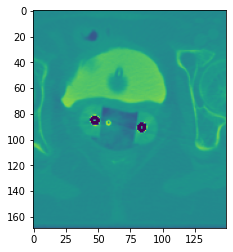

In [ ]:
plt.imshow(getImgBound(2, 10, False, -2000, 2000, 'dImg'))
plt.show()

In [ ]:
for i in range(0, imgs[str(2)]["depth"]):
    # plt.imshow(getImgBound(2, i, False, -150, 11, 'dMask'))
    plt.imshow(getImgBound(2, i, True, 1, 4, 'dMask', -10, 10))
    plt.show()

In [ ]:
img = getImgBound(2, i, False, -150, 11, 'dMask')
img = np.array(img)
img.shape

(169, 150)

In [ ]:
imgs["2"]["depth"]

35

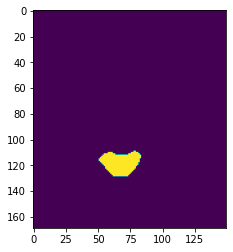

In [ ]:
plt.imshow(getImgBound(2, 6, True, 1, 4, 'dMask', -10, 10))
plt.show()

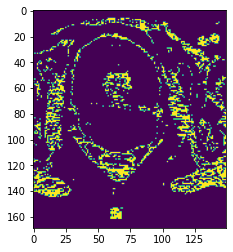

In [ ]:
plt.imshow(getImgBound(2, 6, True, 10, 50, 'dImg', -10, 10))
plt.show()

In [ ]:
def getError(no, z, imgL, imgH, maskL, maskH, percent):
    maskD = getImgBound(no, z, True, maskL, maskH, 'dMask', -10, 10)
    imgD = getImgBound(no, z, True, imgL, imgH, 'dImg', -10, 10)
    maskC = 0
    overlapC = 0
    for i in range(len(maskD)):
        for j in range(len(maskD[i])):
            if maskD[i][j] == 10:
                maskC = maskC + 1
            if maskD[i][j] == 10 and imgD[i][j] == 10:
                overlapC = overlapC + 1
    if maskC * percent / 100 <= overlapC:
        return (0, maskC, overlapC)
    else:
        return (1, maskC, overlapC)
    # return (maskC, overlapC)

In [ ]:
def getError2(no, z, imgL, imgH, maskL, maskH, percent):
    maskD = getImgBound(no, z, True, maskL, maskH, 'dMask', -10, 10)
    imgD = getImgBound(no, z, False, -250, 250, 'dImg', -500, 500)
    maskC = 0
    overlapC = [0 for i in range(100)]
    for i in range(len(maskD)):
        for j in range(len(maskD[i])):
            if maskD[i][j] == 10:
                maskC = maskC + 1
            if maskD[i][j] == 10 and imgD[i][j] >= -250 and imgD[i][j] <= 250:
                overlapC[int((imgD[i][j] + 250) / 5)] = overlapC[int((imgD[i][j] + 250) / 5)] + 1
    # overlapC = [(0 if maskC * percent / 100 <= i else 1, maskC, i) for i in overlapC]
    overlapC = [(0 if maskC * percent / 100 <= i else 1) for i in overlapC]
    return overlapC

In [ ]:
getError2(2, 6, 10, 50, 1, 4, 5)

In [ ]:
def createModel():
    # state
    lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # input layer
    inputLayer = layers.Input(shape=([allBounds["h"], allBounds["w"], 1]))
    # hidden layer
    hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu")(inputLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.Flatten()(hiddenLayer)
    hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # output layer
    outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    outputLayer = outputLayer * 1
    model = tf.keras.Model(inputLayer, outputLayer)
    return model
def createModel2():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(allBounds["h"], allBounds["w"], 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(100, activation='sigmoid'))
    return model
    # # state
    # lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # # input layer
    # inputLayer = layers.Input(shape=([allBounds["h"], allBounds["w"], 1]))
    # # hidden layer
    # hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu")(inputLayer)
    # hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    # hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    # hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    # hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    # hiddenLayer = layers.Flatten()(hiddenLayer)
    # hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # # output layer
    # outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    # outputLayer = outputLayer * 1
    # model = tf.keras.Model(inputLayer, outputLayer)
    # return model

In [ ]:
model2 = createModel2()
model2.summary()
model2.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
res = model2.fit(imgD, imgY, epochs=5)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 167, 148, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 83, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 81, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 40, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 38, 34, 64)        36928     
                                                                 
 flatten_4 (Flatten)         (None, 82688)            

In [ ]:
model = createModel()
modelOptimizer = tf.keras.optimizers.Adam(0.002)
@tf.function
def update(model, nos, imgD, imgY):
    with tf.GradientTape() as tape:
        tY = model(imgD, training=True)
        tY = tY - imgY
        loss = tf.math.reduce_mean(tf.math.square(tY))

    grad = tape.gradient(loss, model.trainable_variables)
    modelOptimizer.apply_gradients(zip(grad, model.trainable_variables))

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 169, 150, 1)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 167, 148, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 83, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 81, 72, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 40, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 38, 34, 64)        3692

In [ ]:
nos = 2
imgD2 = imgD[nos].reshape(1, imgD[nos].shape[0], imgD[nos].shape[1], 1)
imgD2.shape

(1, 169, 150, 1)

In [ ]:
imgY[nos].astype(np.float32)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
for nos in range(len(imgD)):
    imgD2 = imgD[nos].reshape(1, imgD[nos].shape[0], imgD[nos].shape[1], 1)
    imgY2 = imgY[nos].astype(np.float32)
    update(model, nos, imgD2, imgY2)
    print(nos)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
imgD = getImgBound(2, 6, False, -2000, 2000, 'dImg')
imgD = np.array(imgD)
imgD = imgD.reshape((1, imgD.shape[0], imgD.shape[1], 1))
imgD.shape

(1, 169, 150, 1)

In [ ]:
# model.summary()
# imgD = getImgBound(2, 6, False, -2000, 2000, 'dImg')
t = model(imgD)
t

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.6447394 , 0.21048826, 0.34874988, 0.6099661 , 0.35857582,
        0.6815399 , 0.5315963 , 0.55474514, 0.5723875 , 0.38175586,
        0.6768527 , 0.51750046, 0.18788025, 0.76841795, 0.22589377,
        0.8305547 , 0.4496175 , 0.6586615 , 0.8464193 , 0.37898037,
        0.3659333 , 0.44753706, 0.49505284, 0.5551929 , 0.51737183,
        0.4906062 , 0.48197377, 0.14566615, 0.7148074 , 0.10083163,
        0.7754085 , 0.2615009 , 0.5792307 , 0.3700259 , 0.59902203,
        0.48903063, 0.2493046 , 0.35281143, 0.76834166, 0.2808982 ,
        0.60720646, 0.64581406, 0.5428601 , 0.68188643, 0.5146527 ,
        0.43598258, 0.75677514, 0.17150465, 0.11365566, 0.1772367 ,
        0.30637568, 0.19518024, 0.3843719 , 0.34616232, 0.49432522,
        0.6441445 , 0.9050988 , 0.22954142, 0.3327952 , 0.608582  ,
        0.43956998, 0.42139924, 0.83913803, 0.86228377, 0.3512364 ,
        0.39366603, 0.36388987, 0.2890562 , 0.72890854, 0.31817156

In [ ]:
[getError(2, 6, i, i + 5, 1, 4, 5) for i in range(-250, 250, 5)]

[(1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 1),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 1),
 (1, 451, 2),
 (1, 451, 3),
 (1, 451, 0),
 (1, 451, 0),
 (1, 451, 1),
 (1, 451, 1),
 (1, 451, 1),
 (1, 451, 3),
 (1, 451, 3),
 (1, 451, 0),
 (1, 451, 3),
 (1, 451, 5),
 (1, 451, 3),
 (1, 451, 0),
 (1, 451, 1),
 (1, 451, 1),
 (1, 451, 3),
 (1, 451, 6),
 (1, 451, 4),
 (1, 451, 8),
 (1, 451, 7),
 (1, 451, 9),
 (1, 451, 13),
 (1, 451, 12),
 (1, 451, 22),
 (1, 451, 21),
 (1, 451, 16),
 (0, 451, 26),
 (1, 451, 22),
 (0, 451, 24),
 (0, 451, 28),
 (1, 451, 21),
 (1, 451, 21),
 (1, 451, 14),
 (1, 451, 9),
 (1, 451, 10),
 (1, 451, 6),
 (1, 451, 7),
 (1, 451, 5),
 (1, 45

In [ ]:
tt = getError2(2, 6, 1, 4, 1, 4, 5)

In [ ]:
t - tt

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.3552606 , -0.78951174, -0.6512501 , -0.3900339 , -0.6414242 ,
        -0.3184601 , -0.4684037 , -0.44525486, -0.42761248, -0.6182442 ,
        -0.3231473 , -0.48249954, -0.8121197 , -0.23158205, -0.77410626,
        -0.16944528, -0.5503825 , -0.34133852, -0.15358073, -0.6210196 ,
        -0.6340667 , -0.55246294, -0.5049472 , -0.4448071 , -0.48262817,
        -0.5093938 , -0.51802623, -0.8543339 , -0.2851926 , -0.8991684 ,
        -0.2245915 , -0.7384991 , -0.42076927, -0.6299741 , -0.40097797,
        -0.5109694 , -0.7506954 , -0.64718854, -0.23165834, -0.7191018 ,
        -0.39279354, -0.35418594, -0.4571399 , -0.31811357, -0.48534727,
        -0.5640174 , -0.24322486, -0.8284954 , -0.8863443 , -0.8227633 ,
        -0.6936243 , -0.80481976, -0.6156281 , -0.6538377 , -0.5056748 ,
         0.6441445 ,  0.9050988 , -0.7704586 ,  0.3327952 ,  0.608582  ,
         0.43956998,  0.42139924,  0.83913803,  0.86228377, -0.6487636 ,
 